## Introduction

This assessment aims to make you familiar with word embeddings and fine-tuning them for a specific downstream task. This assignment will be in two parts: **Part1: Fasttext** and **Part2: POS Tagging**. The due date of the exercise is **16th of April, 11.59pm**. You are going to submit your work via Blackboard.


## Install PyTorch (If you are working locally)

1. Have the latest version of Anaconda installed on your machine.
2. Create a new conda environment starting from Python 3.7. In this setup example, we'll call it `torch_env`.
3. Run the command: `conda activate torch_env`
4. Run the command: `pip3 install torch==1.13.1`

## or just work on this notebook on google colab.
https://colab.research.google.com/

For this assignment, you don't need a GPU to train the models. However, if you want to use a GPU, you can follow the steps below to create a GPU backed environment. https://www.youtube.com/watch?v=TI9mTiTKoUc&ab_channel=SinaTofighi This video shows how you can open a Colab, request and allocate a GPU for your work. You can follow the steps to create your GPU backed environment.

# COMP542/442 - Assignment 1 - Part 1

The assignment consists of the following parts:
* **Part I**: Preparation
  * Installing the required packages
  * Downloading data
  * Preprocessing
* **Part II**: Model Training
  * Training word embeddings on the Turkish dataset
  * Training with Contuinuous Bag of Words approach (Optional)
  * Trianing with Skipgram approach
* **Part III**: Observations
  * Make observations for get_nearest_neighbors and get_analogies method
  * Compare CBOW with Skipgram (Optional)

##### Inline question 1: Describe n-gram, BPE vs wordpiece/unigram tokenization methods with one or two sentences. Please compare their advantages and disadvantages over each other.

<font color='red'>Your answer: n-gram is a language modeling technique that involves breaking up text into contiguous sequences of n words (or characters) to better capture the dependencies between adjacent words. BPE (Byte Pair Encoding) and WordPiece/Unigram are popular tokenization methods that use subword units to represent words. They are similar to eachother with slight differences such as BPE replaces the most frequent byte pair with a new byte which makes this algorithm a frequency-based model while wordpiece leverages likelihood instead of frequency to merge the best pair. BPE is known for its simplicity and efficient decoding and ability to handle out-of-vocabulary (OOV) words well, while WordPiece/Unigram has the advantage of being more accurate in terms of tokenization and producing more human-interpretable subword units. However, wordPiece/unigram can suffer from OOV words and require additional preprocessing steps since we calculate the likelihood for all symbols (K) which makes the complexity very high, O(K^2), while in BPE similar words can have different subwords, does not have probabilities or scores for possible segmentations, deterministic decoding, and has single output. </font>


## Installing fastText

You may follow the instruction from the documentation:
* https://fasttext.cc/docs/en/support.html
* https://fasttext.cc/docs/en/unsupervised-tutorial.html

In [1]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install .
!python setup.py install
%cd ..

C:\Users\BB\Desktop\Assigment_1\fastText


Cloning into 'fastText'...


Processing c:\users\bb\desktop\assigment_1\fasttext
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-win_amd64.whl size=228964 sha256=95ec021868553518fcfd95cdfe61a16f56973a5369b13c939089bfb99f395ec5
  Stored in directory: C:\Users\BB\AppData\Local\Temp\pip-ephem-wheel-cache-jkpqmfdj\wheels\02\75\1e\2bb97eebf542542fd1c3bbfd731eb725d76e085a4fe5ba3061
Successfully built fasttext


running install
running bdist_egg
running egg_info
writing python/fasttext_module\fasttext.egg-info\PKG-INFO
writing dependency_links to python/fasttext_module\fasttext.egg-info\dependency_links.txt
writing requirements to python/fasttext_module\fasttext.egg-info\requires.txt
writing top-level names to python/fasttext_module\fasttext.egg-info\top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'python/fasttext_module\fasttext.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
running build_ext
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\fasttext
copying build\lib.win-amd64-cpython-38\fasttext\FastText.py -> build\bdist.win-amd64\egg\fasttext
creating build\bdist.win-amd64\egg\fasttext\tests
copying build\lib.win-amd64-cpython-38\fasttext\tests\test_configurations.py -> build\bdist.win-amd64\egg\fasttext\tests
copying build\lib.win-amd64-cpython-38

C:\Users\BB\anaconda3\lib\site-packages\setuptools\dist.py:788: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
C:\Users\BB\anaconda3\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
C:\Users\BB\anaconda3\lib\site-packages\setuptools\command\easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(


In [198]:
# Test if installation was successful
import fasttext

We use the following data for training the embeddings: trwiki-20230401-pages-articles-multistream.xml


**Download preprocessing script**

A raw Wikipedia dump contains a lot of HTML / XML data, for preprocessing it, you may use the script from: https://github.com/hghodrati/wikifil.git

In [2]:
!git clone https://github.com/hghodrati/wikifil.git

fatal: destination path 'wikifil' already exists and is not an empty directory.


In [4]:
# preprocess xml and save to new file
!perl wikifil/wikifil.pl dataset/trwiki-20230401-pages-articles-multistream.xml > dataset/data_embed

The process cannot access the file because it is being used by another process.


In [199]:
# Visualize data
!head -c 80 dataset/data_embed


 one one six two do um yeri onon nehri d l n boldak mo olistan l m tarihi l m 


## Training with fastText

You may find the documentation for training word respresentations here: 
* https://fasttext.cc/docs/en/unsupervised-tutorial.html
* https://fasttext.cc/docs/en/python-module.html#train_unsupervised-parameters

You may use the embedding dimension as 100, which is default by fasttext

In [200]:
import fasttext

EMBEDDING_DIM = 100

You will need to train the word embedding using two approaches:
* Continuous Bag of words
* Skipgram
After training, save the models in their respective paths

You may refer to the tutorial/ documentation for that

In [201]:
%mkdir results
CBOW_EMBED = "results/embed_cbow.bin"
SKIPGRAM_EMBED = "results/embed_skipgram.bin"

A subdirectory or file results already exists.


In [202]:
#embed_model_cbow = fasttext.train_unsupervised("dataset/data_embed", model = "cbow", dim = EMBEDDING_DIM)
#embed_model_cbow.save_model(CBOW_EMBED)
embed_model_cbow = fasttext.load_model(CBOW_EMBED)

In [203]:
#embed_model_skipgram = fasttext.train_unsupervised("dataset/data_embed", model = "skipgram", dim = EMBEDDING_DIM)
#embed_model_skipgram.save_model(SKIPGRAM_EMBED)
embed_model_skipgram = fasttext.load_model(SKIPGRAM_EMBED)

In [204]:
print(embed_model_cbow.words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [205]:
print(embed_model_cbow['kral']) 

[-1.026277   -3.285909    1.8773216   1.2026745  -2.862723    0.35582215
  3.3496633   1.307696    5.106423    1.6444044  -0.75504905  2.7664747
  2.1635878   0.37609613  2.2018158  -5.218342   -1.8235328  -0.07972104
 -7.5874014  -2.0351925  -0.07200696 -3.962251   -6.422708   -1.2449403
 -3.2433043  -0.3991816   1.6811556   2.0227056  -1.4541028  -1.1936781
 -1.2923727   0.8700587   1.8515731  -0.58396846 -4.0909815  -1.0090557
 -0.93535686  6.1117945  -3.545039   -1.6969752  -2.2047672  -2.4836571
  0.10660865 -0.5311459  -1.0160065   2.1151106   3.8185475   1.1273342
  1.1645334   1.8373682  -2.0739777  -2.6991165   2.639548    2.6499512
  5.3779583   0.4747771   1.4675144  -1.987857    1.6209036  -4.7414556
  1.6782322   5.333603    1.5374714  -0.23751381  1.6952997  -0.27999133
 -0.1858443  -2.27748    -1.9907255  -0.5440921   2.6197827  -3.016587
  0.21958521  3.4475646  -0.5941757  -2.2808697   2.3925495  -0.06105692
  2.5040977  -2.0119917  -1.5838467  -3.0431905  -5.387796   

In [8]:
word = ""

In [9]:
embed_model_cbow.get_nearest_neighbors(word)

[(0.0, 'n'),
 (0.0, 'zero'),
 (0.0, 'nine'),
 (0.0, 'l'),
 (0.0, 'three'),
 (0.0, 've'),
 (0.0, 'four'),
 (0.0, 'fruzsina'),
 (0.0, 'slovacko'),
 (0.0, 'dovizi')]

In [10]:
print(embed_model_skipgram['kral']) 

[-0.13298245 -0.04016509  0.39360836  0.4862256   0.20622572 -0.13901009
 -0.03415386  0.06240623  0.00248661 -0.19292882 -0.35777178  0.591437
  0.4882901  -0.21753213 -0.01650698 -0.20769055 -0.3777108   0.01663102
  0.37115124  0.39584032 -0.31063372  0.09664506 -0.2646753   0.4016691
 -0.37485522  0.6960676   0.2189217  -0.1287117   0.20475289 -0.02120434
  0.31856257 -0.00194207  0.7428657  -0.1785729  -0.24715488 -0.2987573
 -0.27828807  1.008717   -0.0029207   0.3096474  -0.09502981  0.29907566
  0.05595673  0.16168763  0.49806488 -0.10143907  0.7906862   0.6222476
  0.341156    0.22385868  0.19504932  0.23430184 -0.6125229   0.32594085
  0.14124203  0.19418907  0.77706945  0.17727612 -0.37319317 -0.0843094
  0.23813118  0.05328131  0.8963781   0.30475956  0.6357826  -0.49366254
 -0.66606164  0.32757568  0.02972706 -0.0517244  -0.13225797  0.14183338
  0.609693    0.36134657 -0.6572207   0.38703966 -0.2159436  -0.8672752
  0.47734267  0.06841794  0.16303249 -0.53804827 -0.390719

In [11]:
embed_model_skipgram.get_nearest_neighbors(word)

[(0.0, 'n'),
 (0.0, 'zero'),
 (0.0, 'nine'),
 (0.0, 'l'),
 (0.0, 'three'),
 (0.0, 've'),
 (0.0, 'four'),
 (0.0, 'fruzsina'),
 (0.0, 'slovacko'),
 (0.0, 'dovizi')]

#### Inline Question 2: Find an example of an analogy that holds, using the `get_analogies` function. Explain the analogy and also how the analogies are calculated.

<font color='red'>Your answer: For my case, we can see if our model can guess what is to England, and what Madrid is to Spain. Since Madrid is the capital of Spain and also a city in Spain, I expect this function to list me some city in England and it did. To calculate an anaolgy, the function calculates the vector difference between target word's vectors and adds the resulting vector to the related word's vector. In other words, it does the following: vector representation of England + (vector representation of Spain - vector representation of Madrid). Finally, the function outputs the closest vector representations to the resulting vector using cosine similarity as distance metric, which are Manchester, leed, liverpool and etc. for my case.</font>


In [12]:
embed_model_skipgram.get_analogies("madrid", "spain", "england")

[(0.8072715997695923, 'manchester'),
 (0.7557413578033447, 'leeds'),
 (0.7529090642929077, 'liverpool'),
 (0.7391054034233093, 'birmingham'),
 (0.7285589575767517, 'ddersfield'),
 (0.7232592701911926, 'manchesterl'),
 (0.718942403793335, 'chelsea'),
 (0.7180668711662292, 'godmanchester'),
 (0.7169960141181946, 'newcastle'),
 (0.7133979797363281, 'leicester')]

# COMP542/442 - Assignment 1 - Part 2

In this assignment, we are implementing an RNN-based POS (Part-of-Speech) tagger using BiLSTM (bidirectional Long Short-Term Memory) networks. 

The assignment consists of the following parts:
* **Part I**: Preparation
  * Installing the required packages
  * Data loading and preprocessing
  * Creating the datasets and dataloaders
* **Part II**: Model Implementation and Training
  * Implementing the BiLSTMPOS Tagger model
  * Defining training and evaluation functions
  * Running the training loop and observing the loss and accuracy
  * Plotting the training metrics such as loss and accuracy
  * Saving the model
* **Part III**: Initializating BiLSTM with fastText Embeddings
  * Loading the fastText model
  * Initializating with fastText and BiLSTM models
  * Training the model
  * Evaluating the model

Throughout the assignment, you will work with a POS dataset to train and test the model to recognize different POS tags for the given sentences. You also have the option to use this notebook on Google Colab that allows you to allocate a GPU for faster training.

For more details about the POS tags, check the following link: https://universaldependencies.org/tr/pos/index.html

# Part I. Preparation

First, we load the Part-of-the-Speech (POS) dataset. Make sure you have downloaded the dataset using the provided script. Check the assignment handout for more details.

In [206]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from typing import List, Tuple, Dict
import numpy as np
import random
from torch.nn.utils.rnn import pad_sequence
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
from collections import Counter

In [207]:
#Set the seeds for reproducibility
SEED = 542

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [208]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [209]:
def parse_file(file_path):
    """
    Parses a file in the Universal Dependencies (UD) annotation style and returns a list of all the sentences in the file.
    Note: The data files you need in this part of the assignemnt are stored under the dataset/ directory. You can open the
    files to have a better understanding of the format. If you want to learn more about the POS tags, you can visit the
    Universal Dependencies website: https://universaldependencies.org/tr/pos/index.html

    The output should be a list of tuples, where each tuple represents a sentence and contains (word, POS tag) pairs for each
    word in the sentence. For example, the following sentence:

    "The quick brown fox jumps over the lazy dog."
    should be represented as:
    [("The", "DET"), ("quick", "ADJ"), ("brown", "ADJ"), ("fox", "NOUN"), ("jumps", "VERB"), ("over", "ADP"), ("the", "DET"), ("lazy", "ADJ"), ("dog", "NOUN"), (".", "PUNCT")]
    
    Args:
    file_path (str): The path to the file to be parsed.
    
    Returns:
    list: A list of tuples, where each tuple represents a sentence and contains (word, POS tag) pairs for each word in the sentence.
    """
    # *****START OF YOUR CODE*****
    
    sentences = []
    with open(file_path, "r", encoding="utf-8") as f:
        sentence = []
        for line in f:    
            if line[0] == "#":  # ignores comment lines 
                continue
            elif line.isspace():  # if end of sentence, adds the most recent sentence's tuples to the biggest array             print(sentence)
                sentences.append(sentence)
                sentence = []
            else:
                parts = line.strip().split("\t")
                word = parts[1]
                pos = parts[3]
                sentence.append((word, pos))
        sentences.append(sentence)  # if last sentence does not end with an empty line
    return sentences

    # *****END OF YOUR CODE*****


In [210]:
def build_vocab(data: List[List[Tuple[str, str]]]) -> Tuple[Dict[str, int], Dict[str, int]]:
    """
    Builds a vocabulary of words and part-of-speech (POS) tags based on the input data. Don't forget to add special tokens (e.g. <PAD>, <UNK>, etc.)

    Args:
    data (List[List[Tuple[str, str]]]): A list of sentences, where each sentence is represented as a list of (word, POS tag) tuples.

    Returns:
    Tuple[Dict[str, int], Dict[str, int]]: A tuple containing two dictionaries. The first dictionary maps words to their index in the vocabulary, and the second dictionary maps POS tags to their index in the vocabulary.
    """  
    # *****START OF YOUR CODE*****
    
    PAD_TOKEN = "<PAD>"
    UNK_TOKEN = "<UNK>"
    
    tokens = [PAD_TOKEN, UNK_TOKEN]
    
    # set keeps track of the unique words
    word_vocab = set()  
    pos_vocab = set()
    
    word_to_idx = {}
    pos_to_idx = {}
    
    for sentence in data:
        for word, pos in sentence:
            word_vocab.add(word)
            pos_vocab.add(pos)
            
    # first assigns the IDs of tokens
    word_to_idx = {token: i for i, token in enumerate(tokens)}
    pos_to_idx = {token: i for i, token in enumerate(tokens)}
            
    # then assigns uniques IDs for each word 
    word_to_idx.update({word: i for i, word in enumerate(word_vocab, start = len(tokens))})
    pos_to_idx.update({pos: i for i, pos in enumerate(pos_vocab, start = len(tokens))})
    
    return word_to_idx, pos_to_idx
    
    # *****END OF YOUR CODE*****

In [211]:
# Parse the training and validation data files using the `parse_file` function
training_data = parse_file("./dataset/train.conllu")
validation_data = parse_file("./dataset/val.conllu")

# Build the vocabulary for the training data using the `build_vocab` function
# The `build_vocab` function returns two dictionaries:
#   - `word_to_idx`: maps words to their index in the vocabulary
#   - `pos_to_idx`: maps POS tags to their index in the vocabulary
word_to_idx, pos_to_idx = build_vocab(training_data)

In [212]:
#Helper functions to convert between indices and human-readable format. You don't need to do anything here.
#Just reading and making sure you understand what's going on is enough.

idx_to_word = {idx: word for word, idx in word_to_idx.items()}
idx_to_pos = {idx: pos for pos, idx in pos_to_idx.items()}

def convert_idx_to_words(indices: torch.tensor) -> str:
    """Converts a sequence of word indices to a human-readable format.
    
    Args:
        indices (torch.tensor): A sequence of word indices.
    
    Returns:
        str: A string representation of the sequence of words.
    """
    return " ".join([idx_to_word[idx.item()] for idx in indices])

def convert_idx_to_pos(indices: torch.tensor) -> str:
    """Converts a sequence of POS tag indices to a human-readable format.
    
    Args:
        indices (torch.tensor): A sequence of POS tag indices.
    
    Returns:
        str: A string representation of the sequence of POS tags.
    """
    return " ".join([idx_to_pos[idx.item()] for idx in indices])

In [213]:
# Helper function used for minibatching. You don't need to do anything here. Just reading and making sure you understand what's going on is enough.

def collate_batch(batch):
    """
    This function collates a batch of sentences into a padded tensor that can be processed by the model.

    Arguments:

    batch: a list of tuples where each tuple contains a sentence and its corresponding POS tags.
    Returns:

    A tuple of two padded tensors: one containing the text data and the other containing the POS tags.
    """
    
    tag_list, text_list = [], []
    for (line, label) in batch:
        text_list.append(line)
        tag_list.append(label)
        
    return (
        pad_sequence(text_list, padding_value=word_to_idx['<PAD>']),
        pad_sequence(tag_list, padding_value=pos_to_idx['<PAD>'])
    )

### Build Vocabulary

In [214]:
class POSDataset(Dataset):
    """
    A class representing a Part-Of-Speech (POS) tagging dataset, which inherits from PyTorch's Dataset class.
    You need to four methods for this class:
    - __init__: Initializes the dataset object.
    - __len__: Returns the number of sentences in the dataset.
    - __getitem__: Returns the i-th sentence in the dataset.
    - vocab_lookup: Converts a sentence represented as a list of word/POS-tag pairs (tuples) to a pair of PyTorch tensors 
                    representing the corresponding sequences of word and POS tag indices. Out of vocabulary words are
                    represented by the index of the "<UNK>" token.
    """

    def __init__(self, data: List[List[Tuple[str, str]]], word_to_idx: Dict, pos_to_idx: Dict):
        """
        Initializes a new POSDataset object.
        Args:
        - data: A list of sentences, where each sentence is a list of word/POS-tag pairs (tuples).
        - word_to_idx: A dictionary mapping words to their corresponding indices.
        - pos_to_idx: A dictionary mapping POS tags to their corresponding indices.
        """
        # *****START OF YOUR CODE*****
        
        self.data = data
        self.word_to_idx = word_to_idx
        self.pos_to_idx = pos_to_idx

        # *****END OF YOUR CODE*****

    def vocab_lookup(self, sentence: List[Tuple[str, str]]) -> Tuple[torch.tensor, torch.tensor]:
        """
        Converts a sentence represented as a list of word/POS-tag pairs (tuples) to a pair of PyTorch tensors
        representing the corresponding sequences of word and POS tag indices. Out of vocabulary words are
        represented by the index of the "<UNK>" token.

        Args:
        - sentence: A list of word/POS-tag pairs (tuples) representing a single sentence.

        Returns:
        A tuple containing two PyTorch tensors, the first representing the sequence of word indices in the sentence,
        and the second representing the sequence of POS tag indices in the sentence.
        """
        # *****START OF YOUR CODE*****
        
        word_indices = []
        pos_indices = []
        
        for word, pos in sentence:
            if word in self.word_to_idx:
                word_indices.append(self.word_to_idx[word])
            else:
                word_indices.append(self.word_to_idx["<UNK>"])

            if pos in self.pos_to_idx:
                pos_indices.append(self.pos_to_idx[pos])
            else:
                pos_indices.append(self.pos_to_idx["<UNK>"])                
         
        word_indices = torch.tensor(word_indices)
        pos_indices = torch.tensor(pos_indices)

        return word_indices, pos_indices
    
        # *****END OF YOUR CODE*****

    
    def __len__(self):
        """
        Returns the number of sentences in the dataset.
        """
        # *****START OF YOUR CODE*****
        
        return len(self.data)

        # *****END OF YOUR CODE*****

    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.tensor]:
        """
        Returns a single sentence from the dataset as a pair of PyTorch tensors representing the corresponding
        sequences of word and POS tag indices.

        Args:
        - idx: The index of the sentence to retrieve.

        Returns:
        A http://localhost:8888/notebooks/Assigment_1/assignment_1.ipynb#tuple containing two PyTorch tensors, the first representing the sequence of word indices in the sentence,
        and the second representing the sequence of POS tag indices in the sentence.
        """
        # *****START OF YOUR CODE*****
        
        sentence = self.data[idx]
        return self.vocab_lookup(sentence)

        # *****END OF YOUR CODE*****


In [215]:
BATCH_SIZE = 64

In [216]:
# This part is preparing the training and validation datasets by creating POSDataset objects 
# using training_data and validation_data. The word_to_idx and pos_to_idx dictionaries created in build_vocab 
# are passed to POSDataset so that each sentence in the datasets can be converted to a tensor of word and POS tag indices.
# Then, DataLoader objects are created for both the training and validation datasets, with BATCH_SIZE batches per iteration. 
# shuffle=True is used to shuffle the order of samples in each batch, which helps to prevent the model from overfitting to the order of the data. 
# collate_batch is used as the function to merge samples into batches, as it pads sequences to the same length and 
# returns two tensors, one for the word indices and one for the POS tag indices.
# This code block is essential to prepare the data for training the model. 
# The training and validation dataloaders can be used in the training loop to iterate over the dataset in batches.

training_dataset = POSDataset(training_data, word_to_idx, pos_to_idx) 
validation_dataset = POSDataset(validation_data, word_to_idx, pos_to_idx) 

training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [217]:
# It is always usefull to see dataset statistics to get a better understanding of the data.
print(f"Unique tokens in word vocabulary: {len(word_to_idx)}")
print(f"Unique tokens in tag vocabulary: {len(pos_to_idx)}")
print()
print(f"Number of training examples: {len(training_dataset)}")
print(f"Number of validation examples: {len(validation_dataset)}")

Unique tokens in word vocabulary: 33488
Unique tokens in tag vocabulary: 19

Number of training examples: 7804
Number of validation examples: 980


In [287]:
training_dataset[4]

(tensor([ 3938, 24842,   871,  2164,  9313,  6489, 29963]),
 tensor([17,  5,  5, 12,  6,  4, 11]))

In [218]:
# Check a random sample from the training dataset to see if the data is correctly loaded.
print("Sample from the dataset:", training_dataset[4])
print()
print("Human-readable version:", convert_idx_to_words(training_dataset[4][0]), convert_idx_to_pos(training_dataset[4][1]))

Sample from the dataset: (tensor([ 3938, 24842,   871,  2164,  9313,  6489, 29963]), tensor([17,  5,  5, 12,  6,  4, 11]))

Human-readable version: Rüzgâr yine güçlü esiyordu esiyor du . NOUN ADV ADV _ VERB AUX PUNCT


# Part 2: Model Implementation and Training

In this part of the assignment, the focus is on Model Implementation and Training. This section involves the following steps:

Implementing the BiLSTM POS Tagger model: In this step, you will create a class called BiLSTMPOSTagger that inherits from nn.Module. This class will be used for implementing the BiLSTM (bidirectional Long Short-Term Memory) network for POS tagging. The BiLSTM model will consist of an Embedding layer, an LSTM layer, a Dropout layer, and a Linear layer to make predictions.

Defining training and evaluation functions: After implementing the model, you will need to define two essential functions for training and evaluation. The train_for_single_epoch function will be responsible for training the model for one epoch on the datasets. The evaluate function will be used for evaluating the model's performance on a given dataset. Both the functions will receive important arguments such as the model, dataset iterator, optimizer, and criterion (loss function).

Running the training loop and observing the loss and accuracy: In this step, you will carry out the actual training. First, you will initialize the model, optimizer, and criterion. Then, you will run the training loop for a certain number of epochs (e.g., 10). In each epoch, you will train the model for one epoch using the train_for_single_epoch function and evaluate its performance on the validation dataset using the evaluate function. Finally, you will print and store the training loss and evaluation accuracy for each epoch.

By the end of Part II, you will have a model that has been trained on the POS tagging dataset, and you can observe how the training process affects the loss and accuracy metrics.

In [219]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        """
        BiLSTM model for POS tagging.
        Check this link for more details: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

        Args:
            input_dim (int): Number of unique words in the vocabulary.
            embedding_dim (int): Dimension of the word embeddings.
            hidden_dim (int): Dimension of the LSTM hidden states.
            output_dim (int): Number of unique POS tags.
            n_layers (int): Number of LSTM layers.
            bidirectional (bool): Whether to use a bidirectional LSTM.
            dropout (float): Probability of dropout, if any.
            pad_idx (int): Index of the <PAD> token in the vocabulary.
        """
        super().__init__()

        # *****START OF YOUR CODE*****
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(2 * hidden_dim if bidirectional else hidden_dim, output_dim)

        # *****END OF YOUR CODE*****
        
    def forward(self, text):
        """
        Perform forward pass through the model.

        Args:
            text (Tensor): Input text of shape [sent len, batch size].

        Returns:
            Tensor: Predictions of shape [sent len, batch size, output dim].
        """
        # *****START OF YOUR CODE*****
        lstm, _ = self.lstm(self.embedding(text))
        return self.linear(self.dropout(lstm))

        # *****END OF YOUR CODE*****

##### Inline question 3: How do you compare the advantages and disadvantages of using a bidirectional LSTM versus a unidirectional LSTM? #####
<font color='red'>Your answer: BiLSTMs can capture both past and future context and are more effective in modeling long-range dependencies which makes it richer in represention of input sequences. However, compared to unidirectional LSTMs, it is computationally more expensive and require more memory since they process the input sequence in two directions. In contrast, unidirectional LSTMs require less memory and are more efficient since it processes in one direction. Especially when past context is less important than future context, it may become sufficant therefore, in some cases, there is no need to use bidirectional LSTMs. The disadvantages of unidirectional LSTMs are, they may produce less informative representations of input sequences and may not be able to capture certain patterns or dependencies of the innput, especially for complex or future context required downstream tasks. </font>

In [273]:
N_LAYERS = 2
HIDDEN_DIM = 100
BIDIRECTIONAL = True
DROPOUT = 0.3

In [274]:
# initialize the model
model = BiLSTMPOSTagger(
    input_dim=len(word_to_idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=len(pos_to_idx),
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=word_to_idx['<PAD>']
)


In [242]:
# See the output of the model for a random sample from the training dataset.
# It is wrapped in torch.no_grad() because we are not training the model.
with torch.no_grad():
    inputs = training_dataset[0][0]
    tag_scores = model(inputs)
    print(tag_scores)

tensor([[-0.0287,  0.0530, -0.0745,  0.0423,  0.0548, -0.0428,  0.0140, -0.0374,
         -0.0127,  0.0346, -0.0746, -0.0047, -0.0071,  0.0921, -0.0606, -0.0456,
         -0.0410, -0.0018, -0.0332],
        [-0.0042,  0.0110, -0.0483,  0.0782,  0.0366, -0.0464,  0.0219, -0.0014,
         -0.0618, -0.0154, -0.0276,  0.0034, -0.0530,  0.0950, -0.0165, -0.0362,
         -0.0011, -0.0131, -0.0418],
        [-0.0304,  0.0489, -0.0350,  0.0815,  0.0159,  0.0119,  0.0119, -0.0447,
         -0.0732,  0.0074, -0.0441, -0.0020, -0.0120,  0.0475, -0.0484, -0.0583,
          0.0081, -0.0082, -0.0433],
        [-0.0290,  0.0802, -0.0417,  0.0795,  0.0093,  0.0053,  0.0198, -0.0315,
         -0.0172, -0.0082, -0.0791,  0.0039,  0.0062,  0.0973, -0.0048, -0.0814,
          0.0077, -0.0140, -0.0912],
        [-0.0224,  0.0104, -0.0510,  0.0984, -0.0028, -0.0477,  0.0022, -0.0906,
         -0.0142,  0.0625, -0.0508,  0.0072,  0.0273,  0.1131, -0.0026, -0.0908,
         -0.0161,  0.0153, -0.0940]])


In [223]:
def train_for_single_epoch(model, iterator, optimizer, criterion, device, tag_pad_idx):
    """
    Trains the model for one epoch on the given iterator with the specified optimizer and criterion.

    Args:
        model: The neural network model to train.
        iterator: The iterator over the training dataset.
        optimizer: The optimizer to use for gradient descent.
        criterion: The loss function to use.
        tag_pad_idx: The index of the padding token in the tag vocabulary.
        tag_unk_idx: The index of the unknown token in the tag vocabulary.

    Returns:
        The average loss and accuracy for the epoch.
    """
    # *****START OF YOUR CODE*****
    
    model.train() # puts the model in training mode
    model = model.to(device=device)  # moves the model parameters to CPU/GPU
    
    epoch_loss = 0
    epoch_accuracy = 0
    
    for text, tag in iterator:        
        
        text = text.to(device)  # moves the tensors to the specified device
        tag = tag.to(device)
        
        y_pred = model(text)
        y_pred = y_pred.view(-1, y_pred.shape[-1])
        tag = tag.view(-1)

        loss = criterion(y_pred, tag)

        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        accuracy = categorical_accuracy(y_pred, tag, tag_pad_idx)
        loss = loss.detach()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
        
    avg_epoch_loss = epoch_loss / len(iterator)
    avg_epoch_accuracy = epoch_accuracy / len(iterator)
    
    return avg_epoch_loss, avg_epoch_accuracy

    # *****END OF YOUR CODE*****

In [122]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns the categorical accuracy between predictions and the ground truth, ignoring pad tokens.
    """
    # *****START OF YOUR CODE*****
    
    preds = preds.argmax(dim=-1)
    
    mask = y != tag_pad_idx # ignores pad tokens
    
    correct = (preds == y) & mask
    num_correct = correct.sum().float()
    num_total = mask.sum().float()
    
    return num_correct / num_total
    
    # *****END OF YOUR CODE*****

In [226]:
def evaluate(model, iterator, tag_pad_idx):
    """
    Evaluate the performance of a BiLSTMPOSTagger model on a given dataset iterator. Use the categorical_accuracy function
    you implemented above to calculate the accuracy on a batch of predictions.

    Args:
    - model: a BiLSTMPOSTagger object.
    - iterator: a DataLoader object containing (text, tags) tuples.
    - tag_pad_idx: an integer representing the index of the padding token in the tag vocabulary.

    Returns:
    - A float representing the categorical accuracy of the model on the given dataset iterator.

    """
    # *****START OF YOUR CODE*****
    
    model.eval() # puts model to evaluation mode
    model = model.to(device=device)  # moves the model parameters to CPU/GPU
    correct = 0

    with torch.no_grad():
        for text, tag in iterator:
            text, tag = text.to(device), tag.to(device)
            preds = model(text)
            
            accuracy = categorical_accuracy(preds, tag, tag_pad_idx)
            correct += accuracy
            
    return correct/len(iterator)

    # *****END OF YOUR CODE*****

In [227]:
# Check the models accuracy without training
accuracy = evaluate(model, validation_dataloader, tag_pad_idx=pos_to_idx['<PAD>'])
print(f'Accuracy before training: {accuracy*100:.2f}%')

Accuracy before training: 6.14%


In [319]:
# Calculate the accuracy of random predictions
epoch_correct = epoch_n_label = random_accuracy = most_frequent_accuracy = 0

# *****START OF YOUR CODE*****
for text, tags in training_dataset:

    predictions = torch.randint(high=len(pos_to_idx), size=tags.shape)  # randomly predics
    
    batch_n_label = tags.numel()
    
    epoch_correct += torch.sum(predictions == tags).item()
    epoch_n_label += batch_n_label

random_accuracy = epoch_correct / epoch_n_label

# *****END OF YOUR CODE*****

print(f'Accuracy of random predictions: {random_accuracy*100:.2f}%')

# Calculate the accuracy of predicting the most frequent class

# Get the most frequent class

# *****START OF YOUR CODE*****

epoch_correct = epoch_n_label = batch_n_label = 0

tag_items = [id.item() for text, tag in training_dataset for id in tag]
most_frequency_class = Counter(tag_items).most_common(1)[0][0]

for text, tags in training_dataset:

    predictions = most_frequency_class
    
    batch_n_label = tags.numel()
    
    epoch_correct += torch.sum(predictions == tags).item()
    epoch_n_label += batch_n_label

most_frequent_accuracy = epoch_correct / epoch_n_label

# *****END OF YOUR CODE*****
print(f'Accuracy of predicting the most frequent class: {most_frequent_accuracy*100:.2f}%')

Accuracy of random predictions: 5.31%
Accuracy of predicting the most frequent class: 29.61%


In [275]:
#Define hyperparameters

NUM_OF_EPOCHS = 10
LEARNING_RATE = 0.001

In [276]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index=pos_to_idx['<PAD>']) #Modify this part if you are using a different padding token.
criterion = criterion.to(device)

In [277]:
loss_history = []
val_accuracy_history = []
train_accuracy_history = []

for x in range(NUM_OF_EPOCHS):
    # Call the train_for_single_epoch function and store the result in the training_loss variable.
    # Call the evaluate function and store the result in the validation_accuracy variable.
    # Print out the current epoch number, training loss, and validation accuracy using the print function and formatted string syntax. 
    # Append the training_loss and validation_accuracy values to their respective history lists (loss_history and accuracy_history).
    # *****START OF YOUR CODE*****
    
    train_loss, train_accuracy = train_for_single_epoch(model, training_dataloader, optimizer, criterion, device, tag_pad_idx=pos_to_idx['<PAD>'])
    
    val_accuracy = evaluate(model, validation_dataloader, tag_pad_idx=pos_to_idx['<PAD>'])
    
    # prints out the epoch number, training loss, and validation accuracy
    print(f"Epoch {x+1}/{NUM_OF_EPOCHS} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}% | Val Accuracy: {val_accuracy*100:.2f}%")
    
    loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)


    # *****END OF YOUR CODE*****

Epoch 1/10 | Train Loss: 1.7700 | Train Accuracy: 47.62% | Val Accuracy: 57.95%
Epoch 2/10 | Train Loss: 1.1258 | Train Accuracy: 63.47% | Val Accuracy: 67.28%
Epoch 3/10 | Train Loss: 0.8861 | Train Accuracy: 71.13% | Val Accuracy: 72.61%
Epoch 4/10 | Train Loss: 0.7409 | Train Accuracy: 75.75% | Val Accuracy: 74.96%
Epoch 5/10 | Train Loss: 0.6379 | Train Accuracy: 79.02% | Val Accuracy: 76.51%
Epoch 6/10 | Train Loss: 0.5526 | Train Accuracy: 81.96% | Val Accuracy: 77.89%
Epoch 7/10 | Train Loss: 0.4818 | Train Accuracy: 84.42% | Val Accuracy: 78.50%
Epoch 8/10 | Train Loss: 0.4202 | Train Accuracy: 86.37% | Val Accuracy: 79.38%
Epoch 9/10 | Train Loss: 0.3615 | Train Accuracy: 88.37% | Val Accuracy: 80.16%
Epoch 10/10 | Train Loss: 0.3094 | Train Accuracy: 90.09% | Val Accuracy: 79.78%


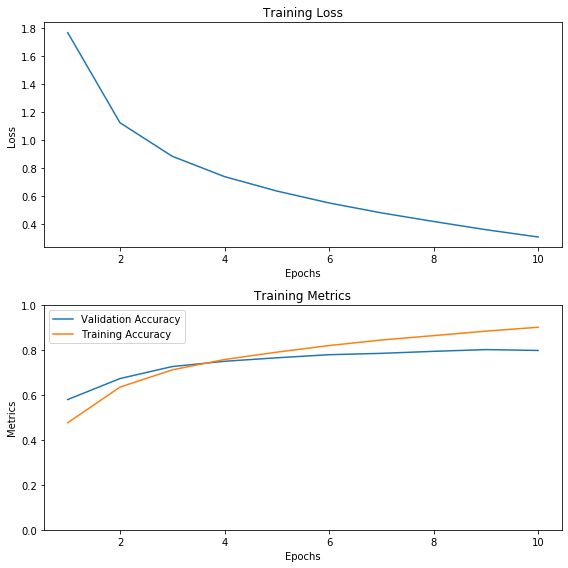

In [278]:
#To plot the training metrics, use the matplotlib library.

# *****START OF YOUR CODE*****

fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(epochs, loss_history, label='Loss')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

axs[1].plot(epochs, val_accuracy_history, label='Validation Accuracy')
axs[1].plot(epochs, train_accuracy_history, label='Training Accuracy')
axs[1].set_title('Training Metrics')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Metrics')
axs[1].legend()
axs[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# *****END OF YOUR CODE*****

In [279]:
# Models accuracy after training
accuracy = evaluate(model, validation_dataloader, tag_pad_idx=pos_to_idx['<PAD>'])
print(f'Accuracy after training: {accuracy*100:.2f}%')

Accuracy after training: 79.80%


In [280]:
# Save the model
torch.save(model.state_dict(), 'pos_tagger_model.pt')

##### Inline question 4: What modifications you need to make to convert this model to a character-level BiLSTM POS tagger?
<font color='red'>Your answer: 1) Instead of using word-level embedding layer, we should use character level embedding in order to generate embeddings for each character and use these generated character embeddings as  input to BiLSTM.
2) We should modify forward() function inside the model, BiLSTMPOSTagger, and evaluate function to take character embeddings as input and compute accuracy at character level, respectively.
3) We should modify the preprocessing step by tokenizing each character and creating a character-level vocabulary
4) We should change input and output dimentions of the model according to character-level vocabulary
5) We should adjust hyperparameters to obtain the most optimal performance</font>

# Part III: Initializing BiLSTM with fastText Embeddings

In Part III of this project, you will be combining the power of fastText embeddings with the sequence modeling capability of the BiLSTM model. You will load the pretrained fastText model for Turkish, which was trained by you on a large corpus of Turkish text. The pre-trained model can generate word embeddings for any Turkish word, including words that are not in the training data for our specific task. This is an effective approach to handling the out-of-vocabulary (OOV) words problem that can occur in natural language processing tasks.

After initializing the models, we will train the model on our dataset and evaluate its performance on a held-out development set (same dataset as above). By combining these two powerful models, we hope to achieve better accuracy and robustness in our POS tagging task.

* Optional: Try the embeddings of both skipgram and cbow approach for your evaluation

In [281]:
# initialize the model
model = BiLSTMPOSTagger(
    input_dim=len(word_to_idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=len(pos_to_idx),
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=word_to_idx['<PAD>']
)

# Load the FastText pre-trained embeddings and set them as the model's embedding layer
pretrained_embeddings = embed_model_cbow
embedding_matrix = np.zeros((len(word_to_idx), embed_model_cbow.get_dimension()))
for word, i in word_to_idx.items():
    embedding_matrix[i] = embed_model_cbow.get_word_vector(word)
pretrained_embeddings = torch.from_numpy(embedding_matrix).float()
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.4588,  0.1896,  0.1541,  ...,  0.7956,  0.3855, -0.3439],
        [ 0.1997,  0.2807, -0.0058,  ...,  0.2573, -0.0287,  0.1034],
        [ 1.2783,  0.8646,  0.6972,  ..., -0.8358, -0.0482,  0.6773],
        ...,
        [-0.0788, -0.6865, -0.9541,  ..., -1.3816, -1.4566, -0.2538],
        [ 0.8242, -0.4210,  3.3412,  ...,  2.3557, -0.8230,  0.2771],
        [ 0.2613, -0.0797, -0.0620,  ..., -0.1662,  0.4528, -0.1195]])

In [282]:
#Define hyperparameters

NUM_OF_EPOCHS = 10
LEARNING_RATE = 0.01

In [283]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index=pos_to_idx['<PAD>'])
criterion = criterion.to(device)

In [284]:
# Plot the loss and accuracy curves
# *****START OF YOUR CODE*****

pretrained_loss_history = []
pretrained_val_accuracy_history = []
pretrained_train_accuracy_history = []

for x in range(NUM_OF_EPOCHS):
   
    train_loss, train_accuracy = train_for_single_epoch(model, training_dataloader, optimizer, criterion, device, tag_pad_idx=pos_to_idx['<PAD>'])
    
    val_accuracy = evaluate(model, validation_dataloader, tag_pad_idx=pos_to_idx['<PAD>'])
    
    # prints out the epoch number, training loss, and validation accuracy
    print(f"Epoch {x+1}/{NUM_OF_EPOCHS} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}% | Val Accuracy: {val_accuracy*100:.2f}%")
    
    pretrained_loss_history.append(train_loss)
    pretrained_train_accuracy_history.append(train_accuracy)
    pretrained_val_accuracy_history.append(val_accuracy)


# *****END OF YOUR CODE*****

Epoch 1/10 | Train Loss: 0.8761 | Train Accuracy: 73.56% | Val Accuracy: 82.07%
Epoch 2/10 | Train Loss: 0.2908 | Train Accuracy: 91.69% | Val Accuracy: 78.37%
Epoch 3/10 | Train Loss: 0.1829 | Train Accuracy: 94.60% | Val Accuracy: 77.13%
Epoch 4/10 | Train Loss: 0.1435 | Train Accuracy: 95.68% | Val Accuracy: 79.24%
Epoch 5/10 | Train Loss: 0.1178 | Train Accuracy: 96.33% | Val Accuracy: 79.52%
Epoch 6/10 | Train Loss: 0.0993 | Train Accuracy: 96.79% | Val Accuracy: 79.90%
Epoch 7/10 | Train Loss: 0.0844 | Train Accuracy: 97.30% | Val Accuracy: 78.81%
Epoch 8/10 | Train Loss: 0.0752 | Train Accuracy: 97.59% | Val Accuracy: 80.07%
Epoch 9/10 | Train Loss: 0.0660 | Train Accuracy: 97.87% | Val Accuracy: 77.62%
Epoch 10/10 | Train Loss: 0.0583 | Train Accuracy: 98.08% | Val Accuracy: 78.07%


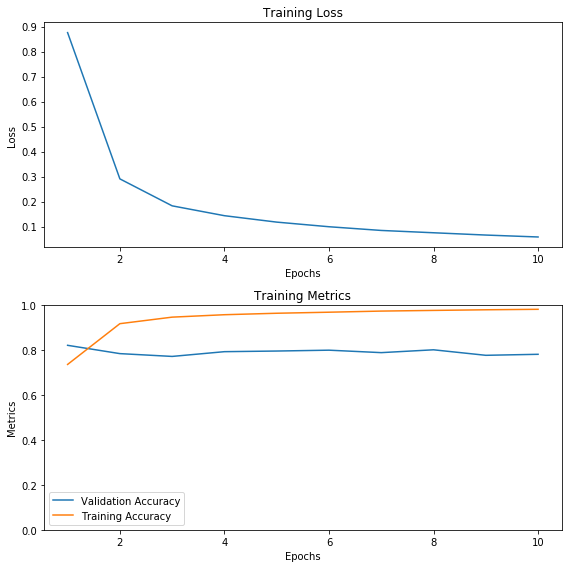

In [285]:
# plots the loss and accuracy curves
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(epochs, pretrained_loss_history, label='Loss')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

axs[1].plot(epochs, pretrained_val_accuracy_history, label='Validation Accuracy')
axs[1].plot(epochs, pretrained_train_accuracy_history, label='Training Accuracy')
axs[1].set_title('Training Metrics')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Metrics')
axs[1].legend()
axs[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()